In [4]:
import numpy as np
import random
import time
import math
import random
import os
import json
import sys
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

random.seed(42)
np.random.seed(42)

# Notebook path
current_directory = os.getcwd()
# Get one behind for calling the other modules
root_directory = os.path.abspath(os.path.join(current_directory, '..'))
sys.path.append(root_directory)

#Network and measures
from to_get_data.net_construction_vis_measures import *

from to_get_data.generate_database import *
#Agrobiodiversity
from to_get_data.agrobiodiversity_data import *

from model_class.Variety import Variety
from model_class.UD_clan import *
from model_class.UD_aleatory_inheritance_clan import *

In [8]:
def diveristy_change(data, inheritance, kinship_system):
    
    palette = sns.color_palette("tab10", len(inheritance))

    plt.figure(figsize=(10, 6))

    for idx, inherit in enumerate(inheritance):
        medias = np.mean(data[1][inherit], axis=0)
        desviaciones = np.std(data[1][inherit], axis=0)

        # Assign colors from tab10 palette
        color = palette[idx]

        if inherit == 'False':
            plt.plot(time_graf, medias, label='Random', color=color)
            # plt.fill_between(time_graf, medias - desviaciones, medias + desviaciones, color=color, alpha=0.2, label=f'Std {inherit}')
        else:
            plt.plot(time_graf, medias, label=f'{inherit} %', color=color)
            # plt.fill_between(time_graf, medias - desviaciones, medias + desviaciones, color=color, alpha=0.2, label=f'Std {inherit}')

    plt.xlabel('Steps')
    plt.ylabel('Diversity at the community level')
    plt.ylim(bottom=0)
    plt.title(f'Diversity change at the community level. {kinship_system}')
    plt.legend()
    plt.grid(True)
    plt.show()
def diversity_different_h_levels(data, inheritance, kinship_system):
    #Define inheritance, calculate mean and std deviation
    mean_div_com = []
    std_div_com = []
    #inheritance = ['0', '25', '50', '75', '100', 'False']
    for i in inheritance:
        mean_div_com.append(np.mean(data[i][1]))
        std_div_com.append(np.std(data[i][1]))

    # Set color palette
    palette = sns.color_palette("tab10")
    color = palette[0]  # Choose the first color from tab10

    # Plot with error bars using a single color
    inheritance_possibilities = ['0', '25', '50', '75', '100', 'Random']
    plt.figure(figsize=(10, 6))
    plt.errorbar(
        inheritance_possibilities,
        mean_div_com,
        yerr=std_div_com,
        fmt='o',
        color=color,
        capsize=5,
        capthick=2,
        ecolor=palette[1],
        label='Data with Error Bars'
    )

    plt.xlabel('Percentage of matrilineal inheritance')
    plt.ylim(0, 10)
    plt.ylabel('Mean')
    plt.title(f'Diversity at the community level with {kinship_system}')
    plt.legend()
    plt.grid(True)
    plt.show()

# General

## Endogamy

In [ ]:
# ENDOGAMY. FINAL CONGIFURATION OF EXPERIMENTS
#Parameters endogamy
experiments = 2
iniciais = 40 # Initial UD
prob_morte = 0.06 # Beta from the gutertz equation
mediao= 4# Average children per UD
#random.seed(42) # Random seed
t = 300 #steps of the simulation
inheritance = [0,25,50,75,100, 'False']
#inheritance = [0,25,50,75,100]
#inheritance = ['False']
view = 50
time_graf = list(range(0, t+1, view))
data_inherit_endo = {}
data_step_mean_var_ud = {}
data_step_var_system = {}
data_step_unique_system = {}
for inherit in inheritance:
    data_step_mean_var_ud[inherit] = []
    data_step_var_system[inherit] = []
    data_step_unique_system[inherit] = []
    media = mediao
    print(f"Experiments with inheritance {inherit}")
    #Lists to store experiments' data
    data_endo_mean_ud = []
    data_endo_com_level = []
    data_endo_total_varieties = []
    original_media = media
    contador = 0
    extintion = 0
    #for exp in range(1, experiments+1):
    while contador < experiments:
        print(f'experimento {contador+1}')
        #### Initialization endogamy
        if inherit != 'False':
            UD_endogamy.uds = {}
            instancias_ud = []
            for id_ud in range(1, int(iniciais) + 1):
                    instancias_ud.append(UD_endogamy(id_ud, media))
            ## Varieties
            limited_varieties = True
            if limited_varieties == False:
                for id_ud, ud in UD_endogamy.uds.items():
                    for _ in range(3):
                        ud.varieties.append(Variety())
            else:
                initial_varieties = [Variety() for _ in range (10)]
                for ud in UD_endogamy.uds.values():
                    random_samples = random.sample(initial_varieties, 3)
                    for sample in random_samples:
                        ud.varieties.append(sample)
            mean_var_ud = []
            var_system = []
            unique_system = []
            var_ud = []
            var_total = []
            for ud in [ud for ud in UD_endogamy.uds.values() if ud.activa ==True]:
                var_ud.append(len(ud.varieties))
                for variety in ud.varieties:
                    var_total.append(variety.variety_id)
            mean_var_ud.append(np.mean(var_ud))
            var_system.append(len(var_total))
            unique_system.append(len(set(var_total)))
            #### Simulation endogamy
            for i in range (1, (t+1)):
                uds_copy = {id_ud: ud for id_ud, ud in UD_endogamy.uds.items() if ud.activa}
                items = list(uds_copy.items())
                random.shuffle(items)
                uds_copy = dict(items)
                alive = len(uds_copy)
                if alive > 200 and (media == original_media): #or media == original_media-1):
                    media -= media//2
                    if media >= 4:
                        media = media //2
                elif alive < 150 and media < original_media:
                    media = original_media
                if not uds_copy:
                    print("acabo")
                    extintion += 1
                    break
                # Cycle: 
                for id_ud, ud in uds_copy.items():
                    ud.ter_filho()
                    ud.buscar_ud(uds_copy, media, inherit)
                    ud.incrementar_idade()
                    ud.death_probability(prob_morte)
                if i%view == 0:
                    var_ud = []
                    var_total = []
                    for ud in [ud for ud in UD_endogamy.uds.values() if ud.activa ==True]:
                        var_ud.append(len(ud.varieties))
                        for variety in ud.varieties:
                            var_total.append(variety.variety_id)
                    mean_var_ud.append(np.mean(var_ud))
                    var_system.append(len(var_total))
                    unique_system.append(len(set(var_total))) 
            if (len([ud for id, ud in uds_copy.items() if ud.activa])) >= 1:   
                total_varieties = []
                varieties_per_UD = []
                for ud in [ud for ud in UD_endogamy.uds.values() if ud.activa ==True]:
                    varieties_per_UD.append(len(ud.varieties))
                    for variety in ud.varieties:
                        total_varieties.append(variety.variety_id)
                data_endo_mean_ud.append(np.mean(varieties_per_UD))
                data_endo_com_level.append(len(set(total_varieties)))
                data_endo_total_varieties.append(total_varieties)
        #data_inherit_endo[inherit] = [data_endo_mean_ud, data_endo_com_level, data_endo_total_varieties]
        else:
            UD_endogamy_al_inh.uds = {}
            instancias_ud = []
            for id_ud in range(1, int(iniciais) + 1):
                    instancias_ud.append(UD_endogamy_al_inh(id_ud, media))
            ## Varieties
            limited_varieties = True
            if limited_varieties == False:
                for id_ud, ud in UD_endogamy_al_inh.uds.items():
                    for _ in range(3):
                        ud.varieties.append(Variety())
            else:
                initial_varieties = [Variety() for _ in range (10)]
                for ud in UD_endogamy_al_inh.uds.values():
                    random_samples = random.sample(initial_varieties, 3)
                    for sample in random_samples:
                        ud.varieties.append(sample)
            mean_var_ud = []
            var_system = []
            unique_system = []
            var_ud = []
            var_total = []
            for ud in [ud for ud in UD_endogamy_al_inh.uds.values() if ud.activa ==True]:
                var_ud.append(len(ud.varieties))
                for variety in ud.varieties:
                    var_total.append(variety.variety_id)
            mean_var_ud.append(np.mean(var_ud))
            var_system.append(len(var_total))
            unique_system.append(len(set(var_total)))
            #### Simulation endogamy
            for i in range (1, (t+1)):
                uds_copy = {id_ud: ud for id_ud, ud in UD_endogamy_al_inh.uds.items() if ud.activa}
                items = list(uds_copy.items())
                random.shuffle(items)
                uds_copy = dict(items)
                alive = len(uds_copy)
                if alive > 200 and (media == original_media): 
                    media -= media//2
                    if media >= 4:
                        media = media //2
                    #print(media)
                elif alive < 150 and media < original_media:
                    media = original_media
                    #print(media)
                if not uds_copy:
                    print("acabo")
                    extintion += 1
                    break
                # Cycle: 
                varieties_list = [var for ud in uds_copy.values() for var in ud.varieties]
                for id_ud, ud in uds_copy.items():
                    ud.ter_filho()
                    ud.buscar_ud(uds_copy, media, varieties_list, 3)
                    ud.incrementar_idade()
                    ud.death_probability(prob_morte)
                if i%view == 0:
                    var_ud = []
                    var_total = []
                    for ud in [ud for ud in UD_endogamy_al_inh.uds.values() if ud.activa ==True]:
                        var_ud.append(len(ud.varieties))
                        for variety in ud.varieties:
                            var_total.append(variety.variety_id)
                    mean_var_ud.append(np.mean(var_ud))
                    var_system.append(len(var_total))
                    unique_system.append(len(set(var_total)))
            if (len([ud for id, ud in uds_copy.items() if ud.activa])) >= 1:
                total_varieties = []
                varieties_per_UD = []
                for ud in [ud for ud in UD_endogamy_al_inh.uds.values() if ud.activa ==True]:
                    varieties_per_UD.append(len(ud.varieties))
                    for variety in ud.varieties:
                        total_varieties.append(variety.variety_id)
                data_endo_mean_ud.append(np.mean(varieties_per_UD))
                data_endo_com_level.append(len(set(total_varieties)))
                data_endo_total_varieties.append(total_varieties)
        alive = (len([ud for id, ud in uds_copy.items() if ud.activa]))
        if alive >= 1: #if there are more than 1 alive we use their data
            if len(mean_var_ud) == len(time_graf):        
                data_step_var_system[inherit].append(var_system)
                data_step_unique_system[inherit].append(unique_system)
                data_step_mean_var_ud[inherit].append(mean_var_ud)
            data_inherit_endo[inherit] = [data_endo_mean_ud, data_endo_com_level, data_endo_total_varieties]
            contador += 1
        #print(contador)
    print(f'{extintion}/{contador+extintion}')
    print(f'extintion/{contador+extintion}')
data_steps_inherit_endo = [data_step_var_system, data_step_unique_system, data_step_mean_var_ud]
# Folder
folder_name = 'results_inheritance_aleatory_clan'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Inherit data
inherit_endo_path = os.path.join(folder_name, 'inherit_data_endo.json')
# By steps
inherit_steps_endo_path = os.path.join(folder_name, 'inherit_steps_data_endo.json')
# Save
with open(inherit_endo_path, 'w') as json_file:
    json.dump(data_inherit_endo, json_file, indent=4)
# Save
with open(inherit_steps_endo_path, 'w') as json_file:
    json.dump(data_steps_inherit_endo, json_file, indent=4)
# Confirmation message
print("Data succesfully saved. :D")

In [10]:
# Folder
folder_name = 'results_inheritance_aleatory_clan'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Inherit data
inherit_endo_path = os.path.join(folder_name, 'inherit_data_endo.json')
inherit_steps_endo_path = os.path.join(folder_name, 'inherit_steps_data_endo.json')
# Load
with open(inherit_endo_path, 'r') as json_file:
        loaded_data_inherit_endo = json.load(json_file)
with open(inherit_steps_endo_path, 'r') as json_file:
        loaded_data_inherit_steps_endo = json.load(json_file)
t = 1000 #steps of the simulation
view = 50
time_graf = list(range(0, t+1, view))
inheritance = ['0', '25', '50', '75', '100', 'False']

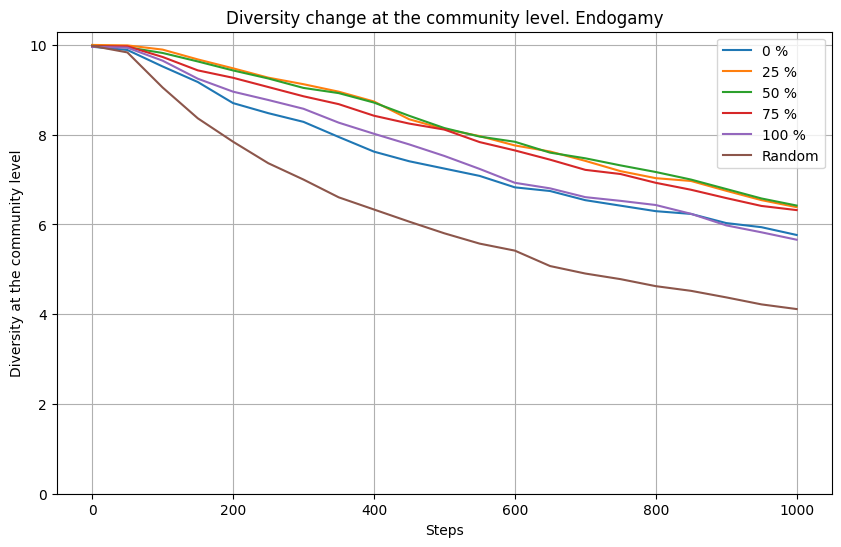

In [6]:
diveristy_change(loaded_data_inherit_steps_endo, inheritance, 'Endogamy')

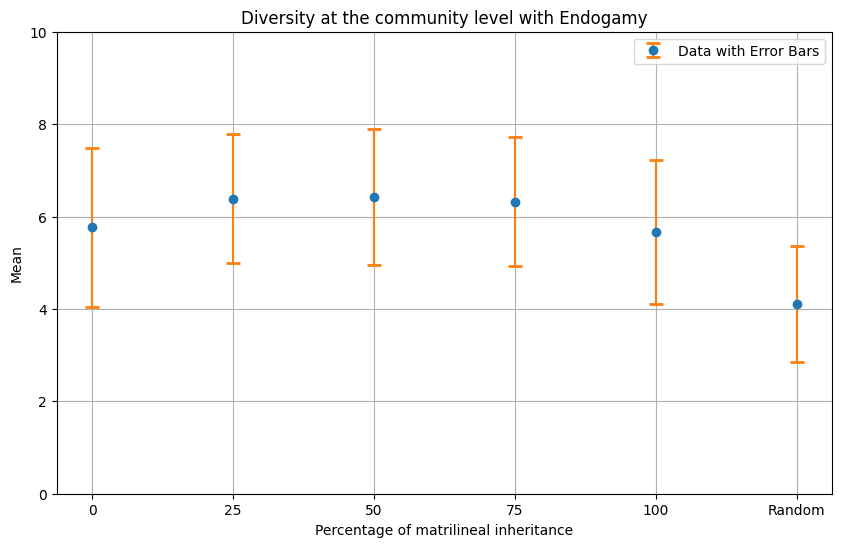

In [13]:
diversity_different_h_levels(loaded_data_inherit_endo, inheritance, 'Endogamy')

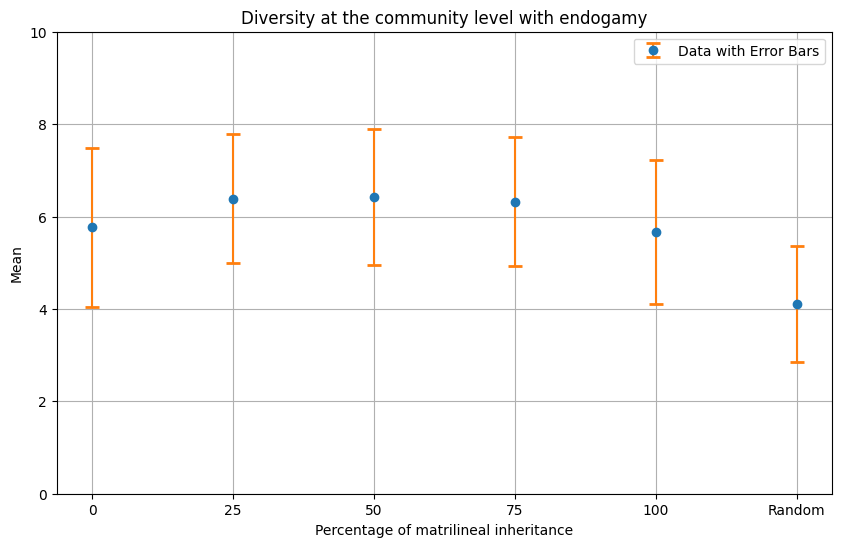

In [7]:
#Define inheritance, calculate mean and std deviation
mean_div_com = []
std_div_com = []
inheritance = ['0', '25', '50', '75', '100', 'False']
for i in inheritance:
    mean_div_com.append(np.mean(loaded_data_inherit_endo[i][1]))
    std_div_com.append(np.std(loaded_data_inherit_endo[i][1]))

# Set color palette
palette = sns.color_palette("tab10")
color = palette[0]  # Choose the first color from tab10

# Plot with error bars using a single color
inheritance_possibilities = ['0', '25', '50', '75', '100', 'Random']
plt.figure(figsize=(10, 6))
plt.errorbar(
    inheritance_possibilities,
    mean_div_com,
    yerr=std_div_com,
    fmt='o',
    color=color,
    capsize=5,
    capthick=2,
    ecolor=palette[1],
    label='Data with Error Bars'
)

plt.xlabel('Percentage of matrilineal inheritance')
plt.ylim(0, 10)
plt.ylabel('Mean')
plt.title('Diversity at the community level with endogamy')
plt.legend()
plt.grid(True)
plt.show()

## Dual organization

In [ ]:
#Esta es la que sirve. QUe hice? solo guardo los finales que terminan con unidades, los otros no. FALTA APLICAR 
# AL GENERALIZED Y LISTOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
#DUAL ORGANIZATION
#Parameters dual_organization
experiments = 100
iniciais = 40 # Initial UD
prob_morte = 0.06 # Beta from the gutertz equation
mediao = 4 # Average children per UD
#random.seed(42) # Random seed
t = 1000 #steps of the simulation
view = 50
time_graf = list(range(0, t+1, view))
inheritance = [0,25,50,75,100, 'False']
#inheritance = ['False']
data_inherit_dual = {}
data_step_mean_var_ud = {}
data_step_var_system = {}
data_step_unique_system = {}
for inherit in inheritance:
    data_step_mean_var_ud[inherit] = []
    data_step_var_system[inherit] = []
    data_step_unique_system[inherit] = []
    media = mediao
    print(f"Experiments with inheritance {inherit}")
    data_dual_mean_ud = []
    data_dual_com_level = []
    data_dual_total_varieties = []
    original_media = media
    contador = 0
    extintion = 0
    while contador < experiments:
    #for exp in range(1,experiments+1):
        mean_var_ud = []
        var_system = []
        unique_system = []
        print(f'experimento {contador+1}')
        #### Initialization dual_organization
        ## Clans
        clans = (list(range(1, 2 + 1)) * (iniciais // 2)) # Just 2 clans
        random.shuffle(clans)
        if inherit != 'False':
            UD_dual_organization.uds = {}
            instancias_ud = []
            for id_ud in range(1, int(iniciais) + 1):
                    instancias_ud.append(UD_dual_organization(id_ud, media, clans.pop()))
            ## Varieties
            limited_varieties = True
            if limited_varieties == False:
                for id_ud, ud in UD_dual_organization.uds.items():
                    for _ in range(3):
                        ud.varieties.append(Variety())
            else:
                initial_varieties = [Variety() for _ in range (10)]
                for ud in UD_dual_organization.uds.values():
                    random_samples = random.sample(initial_varieties, 3)
                    for sample in random_samples:
                        ud.varieties.append(sample)
            mean_var_ud = []
            var_system = []
            unique_system = []
            var_ud = []
            var_total = []
            for ud in [ud for ud in UD_dual_organization.uds.values() if ud.activa ==True]:
                var_ud.append(len(ud.varieties))
                for variety in ud.varieties:
                    var_total.append(variety.variety_id)
            mean_var_ud.append(np.mean(var_ud))
            var_system.append(len(var_total))
            unique_system.append(len(set(var_total)))
            #### Simulation
            for i in range (1, (t+1)):
                uds_copy = {id_ud: ud for id_ud, ud in UD_dual_organization.uds.items() if ud.activa}
                items = list(uds_copy.items())
                random.shuffle(items)
                uds_copy = dict(items)
                alive = len(uds_copy)
                if alive > 200 and (media == original_media): #or media == original_media-1):
                    media -= media//2
                    if media >= 4:
                        media = media //2
                    #print(f' no ano {i} temos a media {media}')
                elif alive < 150 and media < original_media:
                    media = original_media
                    #print(f' no ano {i} temos a media {media}')
                if not uds_copy:
                    extintion += 1
                    print("acabo")
                    break
                # CYcle
                for id_ud, ud in uds_copy.items():
                    ud.ter_filho()
                    ud.buscar_ud(uds_copy, media, inherit, True, 0.2)
                    ud.incrementar_idade()
                    ud.death_probability(prob_morte)
                if i%view == 0:
                    var_ud = []
                    var_total = []
                    for ud in [ud for ud in UD_dual_organization.uds.values() if ud.activa ==True]:
                        var_ud.append(len(ud.varieties))
                        for variety in ud.varieties:
                            var_total.append(variety.variety_id)
                    mean_var_ud.append(np.mean(var_ud))
                    var_system.append(len(var_total))
                    unique_system.append(len(set(var_total))) 
#             #Get the distribution, community diversity and mean by UD
            if (len([ud for id, ud in uds_copy.items() if ud.activa])) >= 1:
                total_varieties = []
                varieties_per_UD = []
                for ud in [ud for ud in UD_dual_organization.uds.values() if ud.activa ==True]:
                    varieties_per_UD.append(len(ud.varieties))
                    for variety in ud.varieties:
                        total_varieties.append(variety.variety_id)
                #mean_ud = np.mean(varieties_per_UD)
                #diversity_comm_level = len(set(total_varieties))
                data_dual_mean_ud.append(np.mean(varieties_per_UD))
                data_dual_com_level.append(len(set(total_varieties)))
                data_dual_total_varieties.append(total_varieties)
        #data_inherit_dual[inherit] = [data_dual_mean_ud, data_dual_com_level, data_dual_total_varieties]
        else:
            UD_dual_organization_al_inh.uds = {}
            instancias_ud = []
            for id_ud in range(1, int(iniciais) + 1):
                    instancias_ud.append(UD_dual_organization_al_inh(id_ud, media, clans.pop()))
            ## Varieties
            limited_varieties = True
            if limited_varieties == False:
                for id_ud, ud in UD_dual_organization_al_inh.uds.items():
                    for _ in range(3):
                        ud.varieties.append(Variety())
            else:
                initial_varieties = [Variety() for _ in range (10)]
                for ud in UD_dual_organization_al_inh.uds.values():
                    random_samples = random.sample(initial_varieties, 3)
                    for sample in random_samples:
                        ud.varieties.append(sample)
            mean_var_ud = []
            var_system = []
            unique_system = []
            var_ud = []
            var_total = []
            for ud in [ud for ud in UD_dual_organization_al_inh.uds.values() if ud.activa ==True]:
                var_ud.append(len(ud.varieties))
                for variety in ud.varieties:
                    var_total.append(variety.variety_id)
            mean_var_ud.append(np.mean(var_ud))
            var_system.append(len(var_total))
            unique_system.append(len(set(var_total)))
            #### Simulation
            for i in range (1, (t+1)):
                uds_copy = {id_ud: ud for id_ud, ud in UD_dual_organization_al_inh.uds.items() if ud.activa}
                items = list(uds_copy.items())
                random.shuffle(items)
                uds_copy = dict(items)
                alive = len(uds_copy)
                if alive > 200 and (media == original_media): #or media == original_media-1):
                    media -= media//2
                    if media >= 4:
                        media = media //2
                    #print(media)
                elif alive < 150 and media < original_media:
                    media = original_media
                    #print(media)
                if not uds_copy:
                    extintion += 1
                    print("acabo")
                    break
                # Cycle: 
                varieties_list = [var for ud in uds_copy.values() for var in ud.varieties]
                for id_ud, ud in uds_copy.items():
                    ud.ter_filho()
                    ud.buscar_ud(uds_copy, media, varieties_list, True, 3, 0.2)
                    ud.incrementar_idade()
                    ud.death_probability(prob_morte)
                if i%view == 0:
                    var_ud = []
                    var_total = []
                    for ud in [ud for ud in UD_dual_organization_al_inh.uds.values() if ud.activa ==True]:
                        var_ud.append(len(ud.varieties))
                        for variety in ud.varieties:
                            var_total.append(variety.variety_id)
                    mean_var_ud.append(np.mean(var_ud))
                    var_system.append(len(var_total))
                    unique_system.append(len(set(var_total))) 
#             #print(len([ud for id, ud in uds_copy.items() if ud.activa]))
#             #Get the distribution, community diversity and mean by UD
            if (len([ud for id, ud in uds_copy.items() if ud.activa])) >= 1:    
                total_varieties = []
                varieties_per_UD = []
                for ud in [ud for ud in UD_dual_organization_al_inh.uds.values() if ud.activa ==True]:
                    varieties_per_UD.append(len(ud.varieties))
                    for variety in ud.varieties:
                        total_varieties.append(variety.variety_id)
                #mean_ud = np.mean(varieties_per_UD)
                #diversity_comm_level = len(set(total_varieties))
                data_dual_mean_ud.append(np.mean(varieties_per_UD))
                data_dual_com_level.append(len(set(total_varieties)))
                data_dual_total_varieties.append(total_varieties)
        alive = (len([ud for id, ud in uds_copy.items() if ud.activa]))
        if alive >= 1: #if there are more than 20 alive we use their data
            #print(f'esta si. {alive}')
            if len(mean_var_ud) == len(time_graf):        
                data_step_var_system[inherit].append(var_system)
                data_step_unique_system[inherit].append(unique_system)
                data_step_mean_var_ud[inherit].append(mean_var_ud)
#                 total_varieties = []
#                 varieties_per_UD = []
#                 for ud in [ud for ud in UD_dual_organization_al_inh.uds.values() if ud.activa ==True]:
#                     varieties_per_UD.append(len(ud.varieties))
#                     for variety in ud.varieties:
#                         total_varieties.append(variety.variety_id)
            data_inherit_dual[inherit] = [data_dual_mean_ud, data_dual_com_level, data_dual_total_varieties]
            contador += 1
        #print(contador)
    print(f'{extintion}/{contador+extintion}')
    print(f'{extintion/(contador+extintion)}')
data_steps_inherit_dual = [data_step_var_system, data_step_unique_system, data_step_mean_var_ud]
# Folder
folder_name = 'results_inheritance_aleatory_clan'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Inherit data
inherit_dual_path = os.path.join(folder_name, 'inherit_data_dual.json')
# By steps
inherit_steps_dual_path = os.path.join(folder_name, 'inherit_steps_data_dual.json')
# Save
with open(inherit_dual_path, 'w') as json_file:
    json.dump(data_inherit_dual, json_file, indent=4)
with open(inherit_steps_dual_path, 'w') as json_file:
    json.dump(data_steps_inherit_dual, json_file, indent=4)
# Confirmation message
print("Data succesfully saved. :D")

In [11]:
t = 1000 #steps of the simulation
view = 50
time_graf = list(range(0, t+1, view))
# Folder
folder_name = 'results_inheritance_aleatory_clan'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Inherit data
inherit_dual_path = os.path.join(folder_name, 'inherit_data_dual.json')
inherit_steps_dual_path = os.path.join(folder_name, 'inherit_steps_data_dual.json')
# Load
with open(inherit_dual_path, 'r') as json_file:
        loaded_data_inherit_dual = json.load(json_file)
with open(inherit_steps_dual_path, 'r') as json_file:
        loaded_data_inherit_steps_dual = json.load(json_file)
inheritance = ['0', '25', '50', '75', '100', 'False']

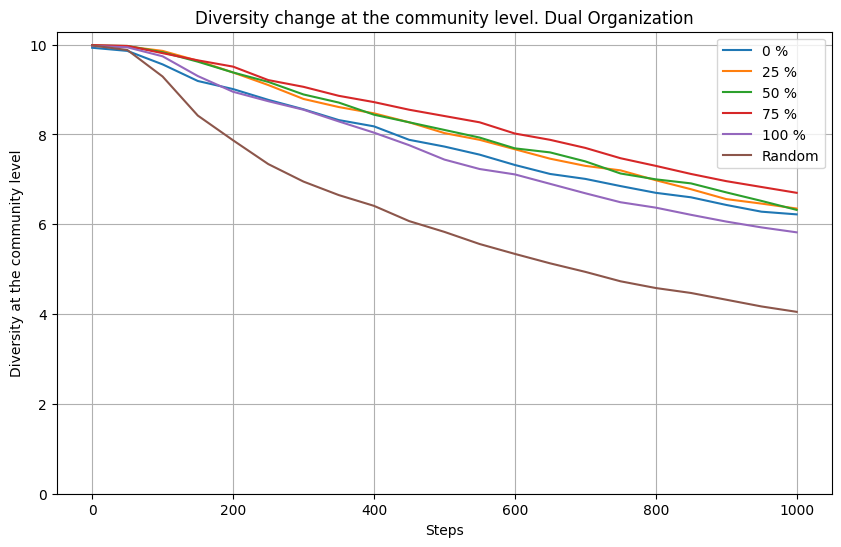

In [94]:
diveristy_change(loaded_data_inherit_steps_dual, inheritance, 'Dual Organization')

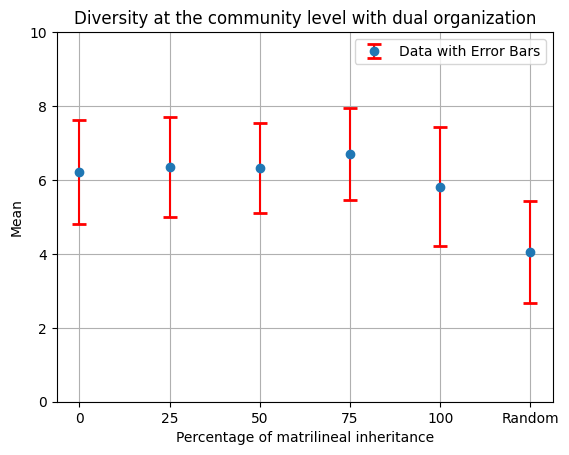

In [95]:
## Data and plot from loaded data
mean_div_com = []
std_div_com = []
inheritance = ['0','25','50','75','100', 'False']
#inheritance = ['False']
#inheritance = [100,90,80,70,60,50, False]
for i in inheritance:
    mean_div_com.append(np.mean(loaded_data_inherit_dual[i][1]))
    std_div_com.append(np.std(loaded_data_inherit_dual[i][1]))
#Plot
inheritance_possibilities = ['0','25','50','75','100', 'Random']
#inheritance_possibilities = ['Random']
plt.errorbar(inheritance_possibilities, mean_div_com, yerr=std_div_com, fmt='o', capsize=5, capthick=2, ecolor='red', label='Data with Error Bars')
plt.xlabel('Percentage of matrilineal inheritance')
plt.ylabel('Mean')
plt.ylim(0,10)
plt.title('Diversity at the community level with dual organization')
plt.legend()
plt.grid(True)
plt.show()

## Generalized

In [ ]:
#UD_generalized
#Parameters Generalized_exchange
experiments = 100
iniciais = 40 # Initial UD
prob_morte = 0.06 # Beta from the gutertz equation
mediao = 4 # Average children per UD
#random.seed(42) # Random seed
t = 1000 #steps of the simulation
inheritance = [0,25,50,75,100, 'False']
#inheritance = [0,25,50,75,100]
#inheritance = ['False']
view = 50
time_graf = list(range(0, t+1, view))
data_inherit_generalized = {}
data_step_mean_var_ud = {}
data_step_var_system = {}
data_step_unique_system = {}
for inherit in inheritance:
    data_step_mean_var_ud[inherit] = []
    data_step_var_system[inherit] = []
    data_step_unique_system[inherit] = []
    media = mediao
    print(f"Experiments with inheritance {inherit}")
    data_generalized_mean_ud = []
    data_generalized_com_level = []
    data_generalized_total_varieties = []
    original_media = media
    contador = 0
    extintion = 0
    while contador < experiments:
    #for exp in range (1, experiments+1):
        mean_var_ud = []
        var_system = []
        unique_system = []
        print(f'experimento {contador+1}')
        #### Initialization generalized_exchange
        ## Clans
        clans = (list(range(1, 4)) * (iniciais // 3 + 1))[:iniciais] # Just 3 clans
        random.shuffle(clans)
        if inherit != 'False':
            UD_generalized.uds = {}
            instancias_ud = []
            for id_ud in range(1, int(iniciais) + 1):
                    instancias_ud.append(UD_generalized(id_ud, media, clans.pop()))
            ## Varieties
            limited_varieties = True
            if limited_varieties == False:
                for id_ud, ud in UD_generalized.uds.items():
                    for _ in range(3):
                        ud.varieties.append(Variety())
            else:
                initial_varieties = [Variety() for _ in range (10)]
                for ud in UD_generalized.uds.values():
                    random_samples = random.sample(initial_varieties, 3)
                    for sample in random_samples:
                        ud.varieties.append(sample)
            mean_var_ud = []
            var_system = []
            unique_system = []
            var_ud = []
            var_total = []
            for ud in [ud for ud in UD_generalized.uds.values() if ud.activa ==True]:
                var_ud.append(len(ud.varieties))
                for variety in ud.varieties:
                    var_total.append(variety.variety_id)
            mean_var_ud.append(np.mean(var_ud))
            var_system.append(len(var_total))
            unique_system.append(len(set(var_total)))
            #### Simulation generalized
            for i in range (1, (t+1)):
                uds_copy = {id_ud: ud for id_ud, ud in UD_generalized.uds.items() if ud.activa}
                items = list(uds_copy.items())
                random.shuffle(items)
                uds_copy = dict(items)
                alive = len(uds_copy)
                if alive > 200 and (media == original_media): 
                    media -= media//2
                    if media >= 4:
                        media = media //2
                    #print(media)
                elif alive < 150 and media < original_media:
                    media = original_media
                    #print(media)
                if not uds_copy:
                    extintion += 1
                    print("acabo")
                    break
                # Cycle
                for id_ud, ud in uds_copy.items():
                    ud.ter_filho()
                    ud.buscar_ud(uds_copy, media, inherit, True, 0.2)
                    ud.incrementar_idade()
                    ud.death_probability(prob_morte)
                if i%view == 0:
                    var_ud = []
                    var_total = []
                    for ud in [ud for ud in UD_generalized.uds.values() if ud.activa ==True]:
                        var_ud.append(len(ud.varieties))
                        for variety in ud.varieties:
                            var_total.append(variety.variety_id)
                    mean_var_ud.append(np.mean(var_ud))
                    var_system.append(len(var_total))
                    unique_system.append(len(set(var_total)))
            #print(len([ud for id, ud in uds_copy.items() if ud.activa]))
            #Get the distribution, community diversity and mean by UD
            if (len([ud for id, ud in uds_copy.items() if ud.activa])) >= 1:
                total_varieties = []
                varieties_per_UD = []
                for ud in [ud for ud in UD_generalized.uds.values() if ud.activa ==True]:
                    varieties_per_UD.append(len(ud.varieties))
                    for variety in ud.varieties:
                        total_varieties.append(variety.variety_id)
                #mean_ud = np.mean(varieties_per_UD)
                #diversity_comm_level = len(set(total_varieties))
                data_generalized_mean_ud.append(np.mean(varieties_per_UD))
                data_generalized_com_level.append(len(set(total_varieties)))
                data_generalized_total_varieties.append(total_varieties)
        else:
            UD_generalized_al_inh.uds = {}
            instancias_ud = []
            for id_ud in range(1, int(iniciais) + 1):
                    instancias_ud.append(UD_generalized_al_inh(id_ud, media, clans.pop()))
            ## Varieties
            limited_varieties = True
            if limited_varieties == False:
                for id_ud, ud in UD_generalized_al_inh.uds.items():
                    for _ in range(3):
                        ud.varieties.append(Variety())
            else:
                initial_varieties = [Variety() for _ in range (10)]
                for ud in UD_generalized_al_inh.uds.values():
                    random_samples = random.sample(initial_varieties, 3)
                    for sample in random_samples:
                        ud.varieties.append(sample)
            mean_var_ud = []
            var_system = []
            unique_system = []
            var_ud = []
            var_total = []
            for ud in [ud for ud in UD_generalized_al_inh.uds.values() if ud.activa ==True]:
                var_ud.append(len(ud.varieties))
                for variety in ud.varieties:
                    var_total.append(variety.variety_id)
            mean_var_ud.append(np.mean(var_ud))
            var_system.append(len(var_total))
            unique_system.append(len(set(var_total)))
            #### Simulation
            for i in range (1, (t+1)):
                uds_copy = {id_ud: ud for id_ud, ud in UD_generalized_al_inh.uds.items() if ud.activa}
                items = list(uds_copy.items())
                random.shuffle(items)
                uds_copy = dict(items)
                alive = len(uds_copy)
                if alive > 200 and (media == original_media):
                    media -= media//2
                    if media >= 4:
                        media = media //2
                    #print(media)
                elif alive < 150 and media < original_media:
                    media = original_media
                    #print(media)
                if not uds_copy:
                    extintion += 1
                    print("acabo")
                    break
                # Cycle: 
                varieties_list = [var for ud in uds_copy.values() for var in ud.varieties]
                for id_ud, ud in uds_copy.items():
                    ud.ter_filho()
                    ud.buscar_ud(uds_copy, media, varieties_list, True, 3, 0.2)
                    ud.incrementar_idade()
                    ud.death_probability(prob_morte)
                if i%view == 0:
                    var_ud = []
                    var_total = []
                    for ud in [ud for ud in UD_generalized_al_inh.uds.values() if ud.activa ==True]:
                        var_ud.append(len(ud.varieties))
                        for variety in ud.varieties:
                            var_total.append(variety.variety_id)
                    mean_var_ud.append(np.mean(var_ud))
                    var_system.append(len(var_total))
                    unique_system.append(len(set(var_total)))
            #print(len([ud for id, ud in uds_copy.items() if ud.activa]))
            #Get the distribution, community diversity and mean by UD
            if (len([ud for id, ud in uds_copy.items() if ud.activa])) >= 1:
                total_varieties = []
                varieties_per_UD = []
                for ud in [ud for ud in UD_generalized_al_inh.uds.values() if ud.activa ==True]:
                    varieties_per_UD.append(len(ud.varieties))
                    for variety in ud.varieties:
                        total_varieties.append(variety.variety_id)
                #mean_ud = np.mean(varieties_per_UD)
                #diversity_comm_level = len(set(total_varieties))
                data_generalized_mean_ud.append(np.mean(varieties_per_UD))
                data_generalized_com_level.append(len(set(total_varieties)))
                data_generalized_total_varieties.append(total_varieties)
        alive = (len([ud for id, ud in uds_copy.items() if ud.activa]))
        if alive >= 20: #if there are more than 20 alive we use their data
            if len(mean_var_ud) == len(time_graf):        
                data_step_var_system[inherit].append(var_system)
                data_step_unique_system[inherit].append(unique_system)
                data_step_mean_var_ud[inherit].append(mean_var_ud)
            #contador += 1
            data_inherit_generalized[inherit] = [data_generalized_mean_ud, data_generalized_com_level, data_generalized_total_varieties]
    print(f'{extintion}/{contador + extintion}')
    print(f'{extintion/(contador + extintion)}')
data_steps_inherit_generalized = [data_step_var_system, data_step_unique_system, data_step_mean_var_ud] 
    
# Folder
folder_name = 'results_inheritance_aleatory_clan'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Inherit data
inherit_generalized_path = os.path.join(folder_name, 'inherit_data_generalized.json')
# By steps
inherit_steps_generalized_path = os.path.join(folder_name, 'inherit_steps_data_generalized.json')
# Save
with open(inherit_generalized_path, 'w') as json_file:
    json.dump(data_inherit_generalized, json_file, indent=4)
with open(inherit_steps_generalized_path, 'w') as json_file:
    json.dump(data_steps_inherit_generalized, json_file, indent=4)
# Confirmation message
print("Data succesfully saved. :D")

In [5]:
t=1000
view = 50
time_graf = list(range(0, t+1, view))
# Folder
folder_name = 'results_inheritance_aleatory_clan'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Inherit data
inherit_restricted_path = os.path.join(folder_name, 'inherit_data_generalized.json')
inherit_steps_restricted_path = os.path.join(folder_name, 'inherit_steps_data_generalized.json')
# Load
with open(inherit_restricted_path, 'r') as json_file:
        loaded_data_inherit_restricted = json.load(json_file)
with open(inherit_steps_restricted_path, 'r') as json_file:
        loaded_data_inherit_steps_restricted = json.load(json_file)
inheritance = ['0', '25', '50', '75', '100', 'False']

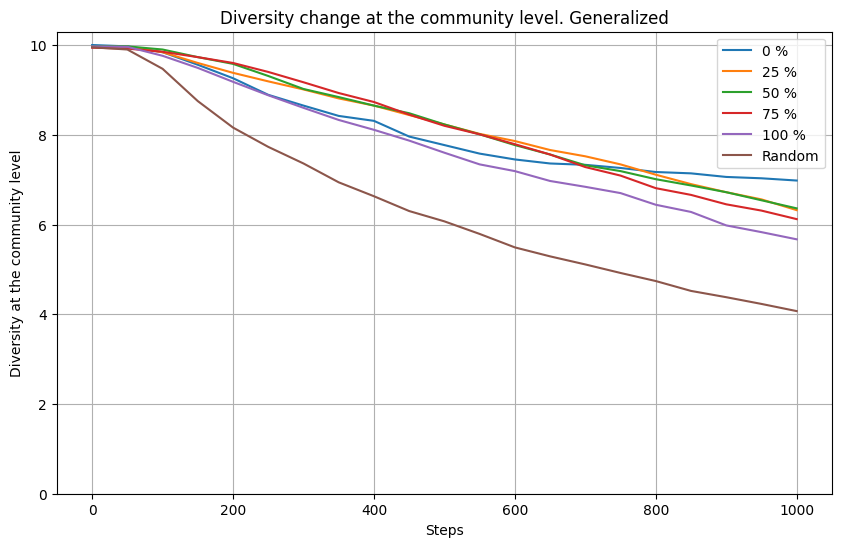

In [9]:
diveristy_change(loaded_data_inherit_steps_restricted, inheritance, 'Generalized')

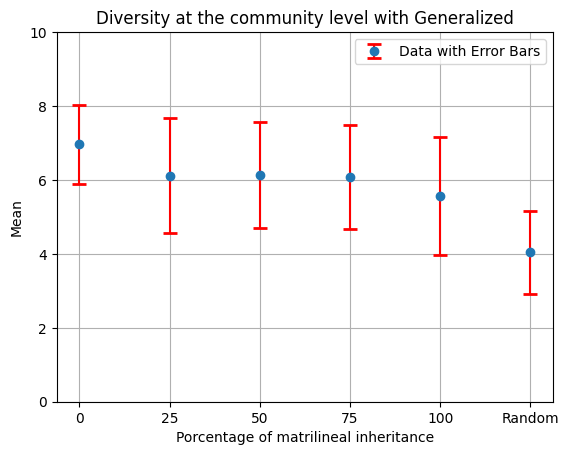

In [7]:
## Data and plot from loaded data
mean_div_com = []
std_div_com = []
inheritance = ['0','25','50','75','100', 'False']
# inheritance = ['False']
#inheritance = [100,90,80,70,60,50, False]
for i in inheritance:
    mean_div_com.append(np.mean(loaded_data_inherit_restricted[i][1]))
    std_div_com.append(np.std(loaded_data_inherit_restricted[i][1]))
#Plot
inheritance_possibilities = ['0','25','50','75','100', 'Random']
# inheritance_possibilities = ['Random']
plt.errorbar(inheritance_possibilities, mean_div_com, yerr=std_div_com, fmt='o', capsize=5, capthick=2, ecolor='red', label='Data with Error Bars')
plt.xlabel('Porcentage of matrilineal inheritance')
plt.ylabel('Mean')
plt.ylim(0,10)
plt.title('Diversity at the community level with Generalized')
plt.legend()
plt.grid(True)
plt.show()

# To visualize all of them at the same time

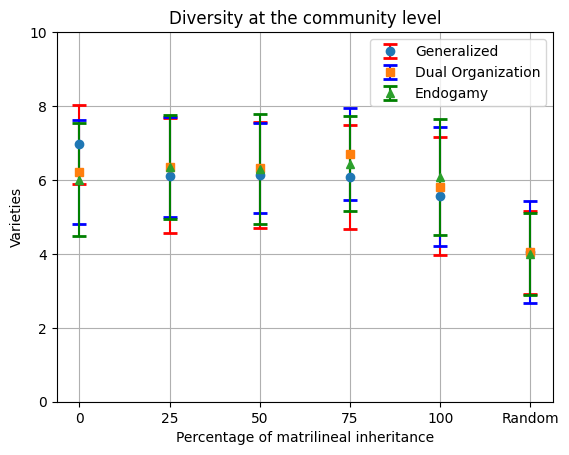

In [100]:
# Lists
mean_div_com_restricted = []
std_div_com_restricted = []
mean_div_com_dual = []
std_div_com_dual = []
mean_div_com_endo = []
std_div_com_endo = []
inheritance = ['0','25','50','75','100', 'False']
# Mean and std
for i in inheritance:
    mean_div_com_restricted.append(np.mean(loaded_data_inherit_restricted[i][1]))
    std_div_com_restricted.append(np.std(loaded_data_inherit_restricted[i][1]))
    mean_div_com_dual.append(np.mean(loaded_data_inherit_dual[i][1]))
    std_div_com_dual.append(np.std(loaded_data_inherit_dual[i][1]))
    mean_div_com_endo.append(np.mean(loaded_data_inherit_endo[i][1]))
    std_div_com_endo.append(np.std(loaded_data_inherit_endo[i][1]))

inheritance_possibilities = ['0','25','50','75','100', 'Random']
#Plot
plt.errorbar(inheritance_possibilities, mean_div_com_restricted, yerr=std_div_com_restricted, fmt='o', capsize=5, capthick=2, ecolor='red', label='Generalized')
plt.errorbar(inheritance_possibilities, mean_div_com_dual, yerr=std_div_com_dual, fmt='s', capsize=5, capthick=2, ecolor='blue', label='Dual Organization')
plt.errorbar(inheritance_possibilities, mean_div_com_endo, yerr=std_div_com_endo, fmt='^', capsize=5, capthick=2, ecolor='green', label='Endogamy')
plt.xlabel('Percentage of matrilineal inheritance')
plt.ylabel('Varieties')
plt.ylim(0,10)
plt.title('Diversity at the community level')
plt.legend()
plt.grid(True)
plt.show()

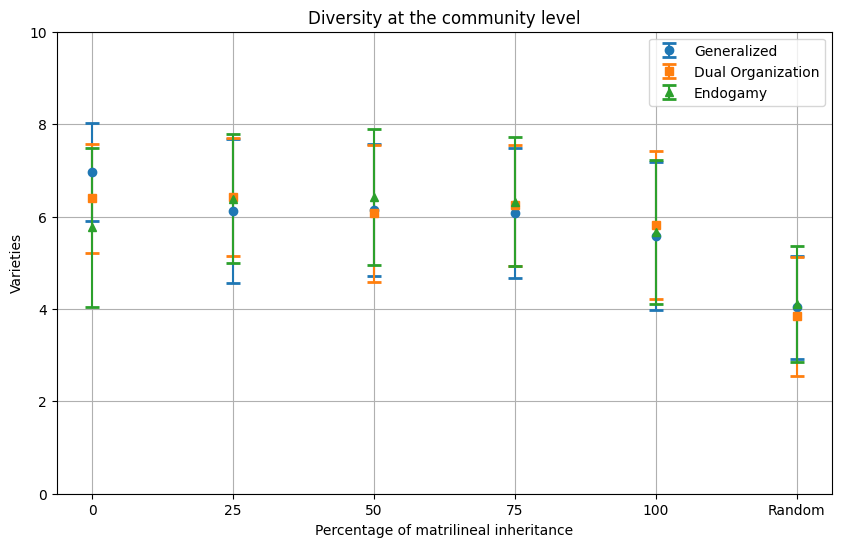

In [12]:
# Define inheritance, calculate means and standard deviations
mean_div_com_restricted = []
std_div_com_restricted = []
mean_div_com_dual = []
std_div_com_dual = []
mean_div_com_endo = []
std_div_com_endo = []
inheritance = ['0', '25', '50', '75', '100', 'False']

# Calculate mean and std deviation
for i in inheritance:
    mean_div_com_restricted.append(np.mean(loaded_data_inherit_restricted[i][1]))
    std_div_com_restricted.append(np.std(loaded_data_inherit_restricted[i][1]))
    mean_div_com_dual.append(np.mean(loaded_data_inherit_dual[i][1]))
    std_div_com_dual.append(np.std(loaded_data_inherit_dual[i][1]))
    mean_div_com_endo.append(np.mean(loaded_data_inherit_endo[i][1]))
    std_div_com_endo.append(np.std(loaded_data_inherit_endo[i][1]))

inheritance_possibilities = ['0', '25', '50', '75', '100', 'Random']

# Set color palette
palette = sns.color_palette("tab10")

# Plot with error bars using colors from tab10
plt.figure(figsize=(10, 6))
plt.errorbar(inheritance_possibilities, mean_div_com_restricted, yerr=std_div_com_restricted,
             fmt='o', capsize=5, capthick=2, color=palette[0], ecolor=palette[0], label='Generalized')
plt.errorbar(inheritance_possibilities, mean_div_com_dual, yerr=std_div_com_dual,
             fmt='s', capsize=5, capthick=2, color=palette[1], ecolor=palette[1], label='Dual Organization')
plt.errorbar(inheritance_possibilities, mean_div_com_endo, yerr=std_div_com_endo,
             fmt='^', capsize=5, capthick=2, color=palette[2], ecolor=palette[2], label='Endogamy')

plt.xlabel('Percentage of matrilineal inheritance')
plt.ylabel('Varieties')
plt.ylim(0, 10)
plt.title('Diversity at the community level')
plt.legend()
plt.grid(True)
plt.show()